Statistical errors of ANN models

In [1]:
import numpy as np
import torch
if torch.cuda.device_count():
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Using cpu')

Using cpu


/home/qubot/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
#load saved model
from Neural_network import NN_net, Plain_fc_block, weight_init, eMNS_Dataset
num_input = 15
num_output = 3
fc_stages = [(num_input,100,1),(100,50,1),(50,25,1)]
fc_network = NN_net(None,fc_stages,None,Plain_fc_block, num_output=num_output)

fc_network = torch.load('EMS_ANN.pt', map_location=device)
fc_network.eval()
fc_network.to(device)

NN_net(
  (total_net): Sequential(
    (0): NN_stages(
      (net): Sequential(
        (0): Plain_fc_block(
          (fc): Linear(in_features=15, out_features=100, bias=True)
          (relu): ReLU()
        )
      )
    )
    (1): NN_stages(
      (net): Sequential(
        (0): Plain_fc_block(
          (fc): Linear(in_features=100, out_features=50, bias=True)
          (relu): ReLU()
        )
      )
    )
    (2): NN_stages(
      (net): Sequential(
        (0): Plain_fc_block(
          (fc): Linear(in_features=50, out_features=25, bias=True)
          (relu): ReLU()
        )
      )
    )
    (3): Linear(in_features=25, out_features=3, bias=True)
  )
)

In [5]:
from ReadData import ReadCurrentAndField 
import glob
import os 

# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
#data = ReadFolder(foldername,filepattern)
train_file_num = 50
data = ReadCurrentAndField (foldername,filepattern, train_file_num)

fileList = glob.glob(foldername+filepattern)

data=data.reshape(train_file_num,21,21,21,18)
position = data[:,0:20:2,0:20:2,0:20:2,:15]
Bfield = data[:,0:20:2,0:20:2,0:20:2,15:]

#find min and max value of input position and Bfield
max_position, max_position_index = torch.max(position.reshape(-1,15), dim=0, keepdim=True)
print(max_position)
min_position, min_position_index = torch.min(position.reshape(-1,15), dim=0, keepdim=True)
print(min_position)

max_Bfield, max_Bfield_index = torch.max(Bfield.reshape(-1,3), dim=0, keepdim=True)
print(max_Bfield)
min_Bfield, min_Bfield_index = torch.min(Bfield.reshape(-1,3), dim=0, keepdim=True)
print(min_Bfield)

print(position.shape)
print(Bfield.shape)


dimp=position.shape
dimB=Bfield.shape

position_norm = (position-min_position.expand(dimp[0],dimp[1],dimp[2],dimp[3],dimp[4]))/(max_position.expand(dimp[0],dimp[1],dimp[2],dimp[3],dimp[4])-min_position.expand(dimp[0],dimp[1],dimp[2],dimp[3],dimp[4]))
Bfield_norm = (Bfield-min_Bfield.expand(dimB[0],dimB[1],dimB[2],dimB[3],dimB[4]))/(max_Bfield.expand(dimB[0],dimB[1],dimB[2],dimB[3],dimB[4])-min_Bfield.expand(dimB[0],dimB[1],dimB[2],dimB[3],dimB[4]))



./Data/MagneticField0.txt
./Data/MagneticField1.txt
./Data/MagneticField2.txt
./Data/MagneticField3.txt
./Data/MagneticField4.txt
./Data/MagneticField5.txt
./Data/MagneticField6.txt
./Data/MagneticField7.txt
./Data/MagneticField8.txt
./Data/MagneticField9.txt
./Data/MagneticField10.txt
./Data/MagneticField11.txt
./Data/MagneticField12.txt
./Data/MagneticField13.txt
./Data/MagneticField14.txt
./Data/MagneticField15.txt
./Data/MagneticField16.txt
./Data/MagneticField17.txt
./Data/MagneticField18.txt
./Data/MagneticField19.txt
./Data/MagneticField20.txt
./Data/MagneticField21.txt
./Data/MagneticField22.txt
./Data/MagneticField23.txt
./Data/MagneticField24.txt
./Data/MagneticField25.txt
./Data/MagneticField26.txt
./Data/MagneticField27.txt
./Data/MagneticField28.txt
./Data/MagneticField29.txt
./Data/MagneticField30.txt
./Data/MagneticField31.txt
./Data/MagneticField32.txt
./Data/MagneticField33.txt
./Data/MagneticField34.txt
./Data/MagneticField35.txt
./Data/MagneticField36.txt
./Data/Magn

In [9]:
#calculate estimated Bfield value of ANN 

B_est_norm=torch.zeros(train_file_num,10,10,10,3)
for i in range (0,train_file_num):
    for j in range (0,position.shape[1]):
        for k in range(0,position.shape[2]):
            for l in range(0,position.shape[3]):
                input=position_norm[i,j,k,l,:].to(device)
                b = input.float().reshape(1,15)
                B_est_norm[i,j,k,l,:]=fc_network(b)

In [10]:
print(B_est_norm.shape)
maxB=max_Bfield.expand(train_file_num,10,10,10,3)
minB=min_Bfield.expand(train_file_num,10,10,10,3)
print(Bfield.shape)

torch.Size([50, 10, 10, 10, 3])
torch.Size([50, 10, 10, 10, 3])


In [16]:
if device == 'cuda':
    B_est_norm=B_est_norm.cpu().detach().numpy()
    Bfield_norm=Bfield_norm.detach().numpy()
    maxB=maxB.detach().numpy()
    minB=minB.detach().numpy()
B_est=B_est_norm*(maxB-minB)+minB
B_real=Bfield[:train_file_num,:,:,:,:]
num_samples=B_est.shape[0]

print(B_est.shape)
print(B_real.shape)
import torch.nn.functional as F
mse = F.mse_loss(torch.tensor(B_est),torch.tensor(B_real),reduction='sum')
rmse = torch.sqrt(mse/num_samples/10*10*10)
print(rmse)


(50, 10, 10, 10, 3)
torch.Size([50, 10, 10, 10, 3])
tensor(3.4067)


/tmp/ipykernel_12347/2286253547.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse = F.mse_loss(torch.tensor(B_est),torch.tensor(B_real),reduction='sum')


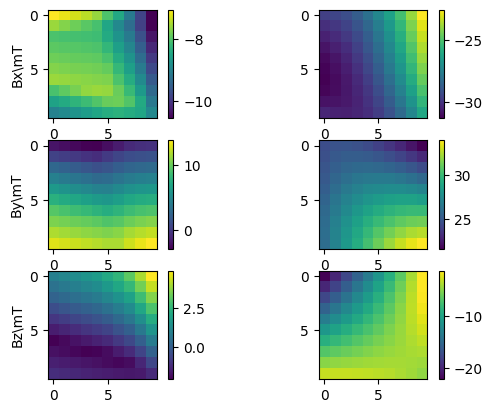

In [17]:
import matplotlib.pyplot as plt
import numpy as np
current_index=3
z_plane_index= 5
# fig, ax = plt.subplots(3, 2)
# fig.tight_layout(h_pad=2)
fig = plt.figure()
vmin=[0.5,  0.4,  0.6]
vmax=[0.65 , 0.55,  0.75]
ylables=['Bx\mT','By\mT','Bz\mT']
# fig.tight_layout(pad=0.4, w_pad=0, h_pad=0)
for i in range(1,4):
    plt.subplot(3,2,2*i-1)
    plt.imshow(B_est[current_index,:,:,z_plane_index,i-1]*1000)    #,vmin=vmin[i-1],vmax=vmax[i-1]
    plt.colorbar()
    plt.ylabel(ylables[i-1])
    plt.subplot(3,2,2*i)
    plt.imshow(B_real[current_index,:,:,z_plane_index,i-1]*1000)
    plt.colorbar()
plt.show()

In [ ]:
# from pylab import *
# subplots_adjust(left=0.0,bottom=0.0,top=1,right=1)
# fig, ax = plt.subplots(1, 3)
# fig.tight_layout()

# for i in range(1,4):
#     plt.subplot(1,3,i)
#     plt.imshow(Error_CNN[current_index,i-1,:,:,z_plane_index])    
#     plt.colorbar(fraction=0.04)    
# plt.show()